In [ ]:
import os
#import splitfolders
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
##
import matplotlib.pyplot as plt
from keras.regularizers import l2
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras import layers, models
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
from skimage.feature import graycomatrix
from skimage import transform
from skimage import color, exposure, morphology, measure
from scipy.ndimage import median_filter
from skimage import feature
from skimage.filters import frangi
from skimage.measure import shannon_entropy
from skimage.morphology import binary_erosion, binary_dilation, disk
from tensorflow.keras.optimizers import Adam

from keras.applications import InceptionV3
from keras import layers, models, optimizers

In [ ]:
# Set the path to your dataset
data_dir = "/content/drive/MyDrive/Kaggle_Dataset"

In [ ]:
# Create an ImageDataGenerator for data augmentation         Data Augmentation
# It generate more images using below parameters
dataset_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')


# this is a generator that will read pictures found in
# at train_data_path, and indefinitely generate
# batches of augmented image data
augmented_data = dataset_datagen.flow_from_directory(data_dir,    # this is the target directory
                                      target_size=(224, 224),    # all images will be resized to 150x150
                                      batch_size=32,
                                      class_mode='binary')       # since we use binary_crossentropy loss, we need binary labels

Found 1482 images belonging to 4 classes.


In [ ]:
augmented_data.class_indices

{'bacterial_blight': 0, 'curl_virus': 1, 'fusarium_wilt': 2, 'healthy': 3}

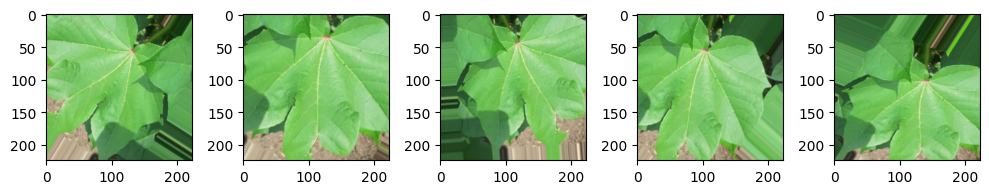

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

images = [augmented_data[0][0][0] for i in range(5)]
plotImages(images)

In [ ]:
classes = ["healthy", "bacterial_blight", "curl_virus", "fusarium_wilt"]
img_size = (224, 224)

def load_and_preprocess_data(data_dir, classes):
    data = []
    labels = []

    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)

        if not os.path.exists(class_dir):
            print(f"Warning: Directory not found for class {class_name}. Skipping.")
            continue

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)

            if not os.path.exists(img_path):
                print(f"Warning: Image not found at {img_path}. Skipping.")
                continue

            img = cv2.imread(img_path)

            if img is None:
                print(f"Warning: Failed to read image at {img_path}. Skipping.")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            data.append(img)
            labels.append(classes.index(class_name))

    data = np.array(data) / 255.0
    labels = np.array(labels)

    return data, labels

data, labels = load_and_preprocess_data(data_dir, classes)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
# Create an InceptionV3 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Create a custom model on top of InceptionV3
inceptionv3_model = models.Sequential()
inceptionv3_model.add(base_model)
inceptionv3_model.add(layers.GlobalAveragePooling2D())
inceptionv3_model.add(layers.Dense(128, activation='relu'))
inceptionv3_model.add(layers.Dropout(0.1))
inceptionv3_model.add(layers.Dense(256, activation='relu'))
inceptionv3_model.add(layers.Dropout(0.25))
inceptionv3_model.add(layers.Dense(4, activation='softmax'))

In [ ]:
# Compile the model
inceptionv3_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Display the model summary
inceptionv3_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [ ]:
model_path13 = '/content/drive/MyDrive/training_models/inceptionv3_kaggle_predictor.h5'
checkpoint = ModelCheckpoint(model_path13, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# Train the Inception V3 model
history = inceptionv3_model.fit(X_train, y_train,
                          epochs=150,
                          verbose=1,
                          validation_split=0.2,
                          callbacks=callbacks_list) # time start 16.06

Epoch 1/150
30/30 [==============================] - ETA: 0s - loss: 1.2748 - accuracy: 0.4156
Epoch 1: val_accuracy improved from -inf to 0.65823, saving model to /content/drive/MyDrive/training_models/inceptionv3_kaggle_predictor.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 21s 332ms/step - loss: 1.2748 - accuracy: 0.4156 - val_loss: 1.0569 - val_accuracy: 0.6582
Epoch 2/150
29/30 [============================>.] - ETA: 0s - loss: 0.9211 - accuracy: 0.6767
Epoch 2: val_accuracy improved from 0.65823 to 0.73840, saving model to /content/drive/MyDrive/training_models/inceptionv3_kaggle_predictor.h5
30/30 [==============================] - 3s 110ms/step - loss: 0.9200 - accuracy: 0.6751 - val_loss: 0.8050 - val_accuracy: 0.7384
Epoch 3/150
29/30 [============================>.] - ETA: 0s - loss: 0.7116 - accuracy: 0.7651
Epoch 3: val_accuracy improved from 0.73840 to 0.78481, saving model to /content/drive/MyDrive/training_models/inceptionv3_kaggle_predictor.h5
30/30 [==============================] - 4s 121ms/step - loss: 0.7087 - accuracy: 0.7669 - val_loss: 0.6350 - val_accuracy: 0.7848
Epoch 4/150
30/30 [==============================] - ETA: 0s - loss: 0.5513 - accuracy: 0.8302
Epoch 4: val_accuracy improved from

In [ ]:
# Evaluate the Xception model
print("[INFO] Calculating model accuracy")
scores = inceptionv3_model.evaluate(X_train, y_train)
print(f"Training Accuracy: {round(scores[1], 4) * 100}%")

print("[INFO] Calculating model accuracy")
scores = inceptionv3_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {round(scores[1], 4) * 100}%")

[INFO] Calculating model accuracy
38/38 [==============================] - 4s 105ms/step - loss: 0.0127 - accuracy: 0.9958
Training Accuracy: 99.58%
[INFO] Calculating model accuracy
10/10 [==============================] - 2s 256ms/step - loss: 0.2073 - accuracy: 0.9596
Test Accuracy: 95.96000000000001%


In [ ]:
inceptionv3_predictions_test = inceptionv3_model.predict(X_test)
inceptionv3_predictions_test = np.argmax(inceptionv3_predictions_test, axis=1)

10/10 [==============================] - 2s 70ms/step


In [ ]:
inceptionv3_eval = inceptionv3_model.evaluate(X_test, y_test)
inceptionv3_accuracy = inceptionv3_eval

10/10 [==============================] - 1s 68ms/step - loss: 0.2073 - accuracy: 0.9596


In [ ]:
inceptionv3_eval

[0.207278773188591, 0.9595959782600403]

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

class_labels = ["bacterial blight", "fusarium wilt", "curl virus", "healthy"]
def evaluate_model(inceptionv3_predictions_test, y_test, model_name):
    accuracy = accuracy_score(y_test, inceptionv3_predictions_test)
    precision = precision_score(y_test, inceptionv3_predictions_test, average='weighted')
    recall = recall_score(y_test, inceptionv3_predictions_test, average='weighted')
    f1 = f1_score(y_test, inceptionv3_predictions_test, average='weighted')
    conf_matrix = confusion_matrix(y_test, inceptionv3_predictions_test)
    plt.figure(figsize=(7, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True/Actual')
    plt.show()

    class_report = classification_report(y_test, inceptionv3_predictions_test, target_names=class_labels)
    print('Classification Report:')
    print(class_report)

    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

      # Return the metrics
    return accuracy, precision, recall, f1

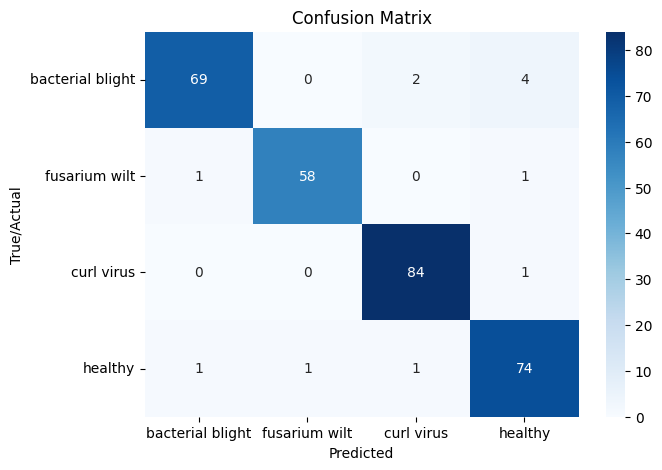

Classification Report:
                  precision    recall  f1-score   support

bacterial blight       0.97      0.92      0.95        75
   fusarium wilt       0.98      0.97      0.97        60
      curl virus       0.97      0.99      0.98        85
         healthy       0.93      0.96      0.94        77

        accuracy                           0.96       297
       macro avg       0.96      0.96      0.96       297
    weighted avg       0.96      0.96      0.96       297

Results for Inception V3:
Accuracy: 0.9595959595959596
Precision: 0.9601492939675456
Recall: 0.9595959595959596
F1 Score: 0.9595523535083748


In [ ]:
accuracy, precision, recall, f1 = evaluate_model(inceptionv3_predictions_test, y_test, "Inception V3")

In [ ]:
inceptionv3_predictions_train = inceptionv3_model.predict(X_train)
inceptionv3_predictions_train = np.argmax(inceptionv3_predictions_train, axis=1)

38/38 [==============================] - 2s 64ms/step


In [ ]:
inceptionv3_eval_train = inceptionv3_model.evaluate(X_train, y_train)
inceptionv3_accuracy = inceptionv3_eval_train

38/38 [==============================] - 3s 70ms/step - loss: 0.0127 - accuracy: 0.9958


In [ ]:
inceptionv3_eval_train

[0.012706064619123936, 0.9957805871963501]

In [ ]:
class_labels = ["bacterial blight", "fusarium wilt", "curl virus", "healthy"]
def evaluate_model(inceptionv3_predictions_train, y_train, model_name):
    accuracy = accuracy_score(y_train, inceptionv3_predictions_train)
    precision = precision_score(y_train, inceptionv3_predictions_train, average='weighted')
    recall = recall_score(y_train, inceptionv3_predictions_train, average='weighted')
    f1 = f1_score(y_train, inceptionv3_predictions_train, average='weighted')
    conf_matrix = confusion_matrix(y_train, inceptionv3_predictions_train)
    plt.figure(figsize=(7, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True/Actual')
    plt.show()

    class_report = classification_report(y_train, inceptionv3_predictions_train, target_names=class_labels)
    print('Classification Report:')
    print(class_report)

    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

      # Return the metrics
    return accuracy, precision, recall, f1

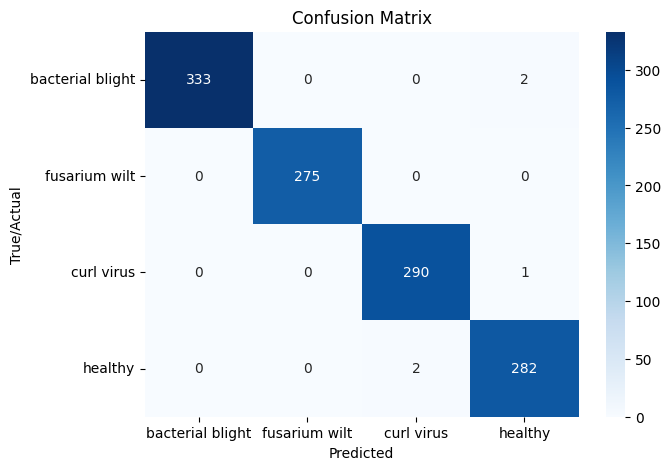

Classification Report:
                  precision    recall  f1-score   support

bacterial blight       1.00      0.99      1.00       335
   fusarium wilt       1.00      1.00      1.00       275
      curl virus       0.99      1.00      0.99       291
         healthy       0.99      0.99      0.99       284

        accuracy                           1.00      1185
       macro avg       1.00      1.00      1.00      1185
    weighted avg       1.00      1.00      1.00      1185

Results for Inception V3:
Accuracy: 0.9957805907172996
Precision: 0.9957952536969266
Recall: 0.9957805907172996
F1 Score: 0.9957839430885519


In [ ]:
accuracy, precision, recall, f1 = evaluate_model(inceptionv3_predictions_train, y_train, "Inception V3")

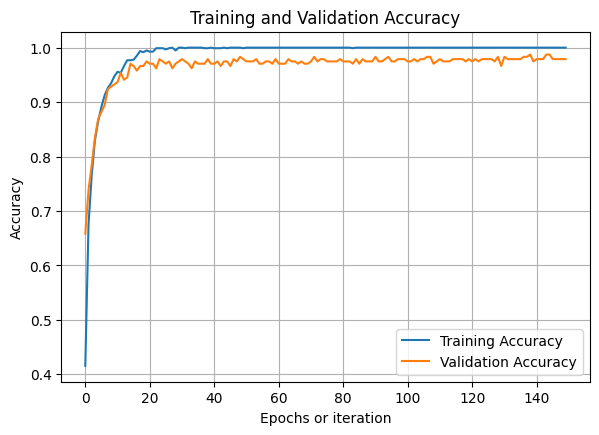

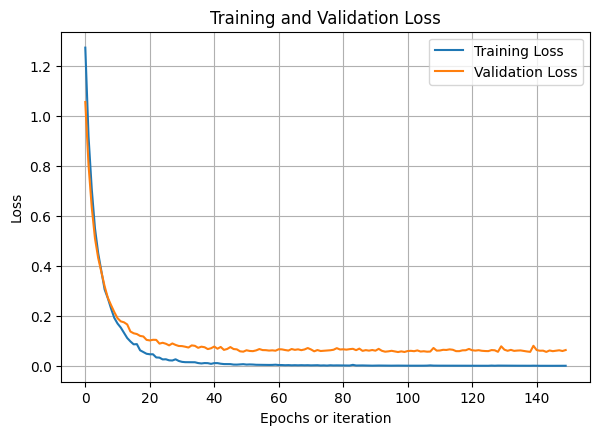

In [ ]:
#plt.figure(figsize=(10, 5))
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
# (2,2) means Width and Height of Diagram
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs or iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs or iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()